In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as plt
import matplotlib.dates as mdates
plt.style.use('Solarize_Light2')
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
class timeseries_decompose(APIView):
    def post(self, request):
        #auth_keyword, token = get_authorization_header(request).split()
        #token = token.decode("utf-8")
        #check = headercheck(token)
        check = 'ok'
        if check == 'ok':
            pass
        else:
            return Response({"status": "validation", "error": "user has been killed"})
        data = request.data
        #file = request.FILES.get("File")
        path=data['path']
        #analysis = data['analysis_name']
        #filename = data['filename']
        #version = data['version']
        #username = data['username']
        date = data['date']
        try:
            import numpy as np
            #file = match_version(version, analysis, filename)
            #data = read_file(file)  # spark data frame
            #if str(type(data)) == "<class 'str'>":
             #   data = read_file(filename)
            #data = data.toPandas()
            df=pd.read_csv(path)
            #df=pd.DataFrame(targetparameter)
            #df[date]=date
            df[date] = pd.to_datetime(df[date])
            df = df.sort_values(by=date)
            df.set_index(date, inplace=True)
            df=df.astype(float)
            print(df.head())
            decomposition = sm.tsa.seasonal_decompose(df, period=30)
            trend = decomposition.trend
            print(trend.head())
            seasonal = decomposition.seasonal
            print(seasonal.head( ))
            residual = decomposition.resid
            print(residual.head( ))
            #trend,seasonal,residual=seasonal_decompose(df)
            return Response({'status':'success'})

        except Exception as e:
            traceback.print_exc()
            return Response({"status": "failure","error":"Please refer the logs in Logs->Container Log"})



def check_stationary(df,targetparameter,check_stationary_type, differencing):
    if check_stationary_type == 'Rolling_statistics':
        if differencing == 'no':
            w = int(input('Enter Windowing Number:'))
            df['rolling_mean'] = df[targetparameter].rolling(window=w).mean()
            df['rolling_std'] = df[targetparameter].rolling(window=w).std()
            return df.index ,df
        elif differencing == 'yes':
            w = int(input(' Enter Windowing Number:'))
            s = int(input(' No.Of.Differencing Required:'))
            df1 = df - df.shift(s)
            df1['rolling_mean'] = df1[targetparameter].rolling(window=w).mean()
            df1['rolling_std'] = df1[targetparameter].rolling(window=w).std()
            return df1.index, df1

    elif check_stationary_type == 'ADFTest':
        if differencing == 'no':
            dftest = adfuller(df[targetparameter], autolag='AIC')
            print(type(dftest))
            Test_stats = dftest[0]
            P_value = dftest[1]
            C_value = dftest[4]
            test = pd.DataFrame([Test_stats, P_value, C_value], columns=[check_stationary_type])
            return df,test

        elif differencing == 'yes':
            s = int(input('No.Of.Differencing Required:'))
            df1 = df[targetparameter] - df[targetparameter].shift(s)
            dftest = adfuller(df1.dropna( ), autolag='AIC')
            Test_stats = dftest[0]
            P_value = dftest[1]
            C_value = dftest[4]
            test = pd.DataFrame([Test_stats, P_value, C_value], columns=[check_stationary_type])
            return df1,test
    
    elif check_stationary_type =='JohansenTest':
        if differencing =='no':
            det_order=int(input('Enter Det_order:')) # should be in -1 to 1 --> (-1,0,1)
            #k_ar_diff =int(input('Enter Number of lagged differences in the model:')) # --> lag values
            data=df[targetparameter]
            joh_model = coint_johansen(data,det_order,0)
            trace_stats = pd.DataFrame([joh_model.lr1],index=["trace_stat"])
            trace_stats=trace_stats.T
            cvt=pd.DataFrame(joh_model.cvt,columns=['conf_interval_90%','conf_interval_95%','conf_interval_99%'])
            return trace_stats,cvt
        elif differencing =='yes':
            det_order=int(input('Enter Det_order:')) # should be in -1 to 1 --> (-1,0,1)
            k_ar_diff =int(input('Enter Number of lagged differences in the model:')) # --> lag values
            data=df[targetparameter]
            joh_model = coint_johansen(data,det_order,k_ar_diff)
            trace_stats = pd.DataFrame([joh_model.lr1],index=["trace_stat"])
            trace_stats=trace_stats.T
            cvt=pd.DataFrame(joh_model.cvt,columns=['conf_interval_90%','conf_interval_95%','conf_interval_99%'])
            return trace_stats,cvt

class timeseries_stationary(APIView):
    def post(self,request):
        #auth_keyword, token = get_authorization_header(request).split()
        #token = token.decode("utf-8")
        #check = headercheck(token)
        check ='ok'
        if check == 'ok':
            pass
        else:
            return Response({"status": "validation", "error": "user has been killed"})
        data = request.data
        path=data['path']
        date=data['date']
        targetparameter = data['targetparameter']
        check_stationary_type = data['check_stationary_type']
        differencing = data['differencing']
        try:
            import numpy as np
            #file = match_version(version, analysis, filename)
            #data = read_file(file)  # spark data frame
            #if str(type(data)) == "<class 'str'>":
             #   data = read_file(filename)
            #data = data.toPandas()
            df=pd.read_csv(path)
            df[date] = pd.to_datetime(df[date])
            df[targetparameter] = df[targetparameter].astype(float)
            df = df.sort_values(by=date)
            df.set_index(date, inplace=True)
            df,output=check_stationary(df,targetparameter,check_stationary_type,differencing)
            print(df)
            print(output)
            return Response({'status':'success'})
        except Exception as e:
            traceback.print_exc()
            return Response({"status": "failure","error":"Please refer the logs in Logs->Container Log"})

def acf_pacf_datapoints(df):
    acf=sm.graphics.tsa.acf(df,alpha=0.05)
    alag=pd.DataFrame(acf[0],columns=['acf_lag'])
    acf_conf=acf[1]-acf[0][:,None]
    acf_conf=pd.DataFrame(acf_conf,columns=['min','max'])
    
    pacf=sm.graphics.tsa.pacf(df,alpha=0.05)
    palag=pd.DataFrame(pacf[0],columns=['pacf_lag'])
    pacf_conf=pacf[1]-pacf[0][:,None]
    pacf_conf=pd.DataFrame(pacf_conf,columns=['min','max'])
    return alag,acf_conf,palag,pacf_conf

class acf_pacf_plot(APIView):
    def post(self,request):
        #auth_keyword, token = get_authorization_header(request).split()
        #token = token.decode("utf-8")
        #check = headercheck(token)
        check ='ok'
        if check == 'ok':
            pass
        else:
            return Response({"status": "validation", "error": "user has been killed"})
        data=request.data
        #analysis = data['analysis_name']
        #filename = data['filename']
        #version = data['version']
        #username = data['username']
        path=data['path']
        date = data['date']
        targetparameter = data['targetparameter']
        try:
            import numpy as np
            #file = match_version(version, analysis, filename)
            #data = read_file(file)  # spark data frame
            #if str(type(data)) == "<class 'str'>":
             #   data = read_file(filename)
            #data = data.toPandas()
            df=pd.read_csv(path)
            df[date] = pd.to_datetime(df[date])
            df[targetparameter] = df[targetparameter].astype(float)
            df = df.sort_values(by=date)
            df.set_index(date, inplace=True)
            alag,acf_conf,palag,pacf_conf=acf_pacf_datapoints(df)
            print(alag)
            print(palag)
            return Response({'status':'success'})


In [7]:
from statsmodels.graphics.tsaplots import acf, pacf

In [24]:
def acf_pacf_datapoints(df):
    acf=sm.graphics.tsa.acf(df,alpha=0.05)
    alag=pd.DataFrame(acf[0],columns=['acf_lag'])
    print(alag.head())
    acf_conf=acf[1]-acf[0][:,None]
    acf_conf=pd.DataFrame(acf_conf,columns=['min','max'])
    print(acf_conf.head())
    
    
    pacf=sm.graphics.tsa.pacf(df,alpha=0.05)
    palag=pd.DataFrame(pacf[0],columns=['pacf_lag'])
    print(palag.head())
    pacf_conf=pacf[1]-pacf[0][:,None]
    pacf_conf=pd.DataFrame(pacf_conf,columns=['min','max'])
    print(pacf_conf.head())
    return alag,acf_conf,palag,pacf_conf
alag,acf_conf,palag,pacf_conf=acf_pacf_datapoints(df)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


    acf_lag
0  1.000000
1  0.774268
2  0.630287
3  0.585293
4  0.577746
        min       max
0  0.000000  0.000000
1 -0.032442  0.032442
2 -0.048107  0.048107
3 -0.056130  0.056130
4 -0.062222  0.062222
   pacf_lag
0  1.000000
1  0.774480
2  0.076997
3  0.189378
4  0.152077
        min       max
0  0.000000  0.000000
1 -0.032442  0.032442
2 -0.032442  0.032442
3 -0.032442  0.032442
4 -0.032442  0.032442


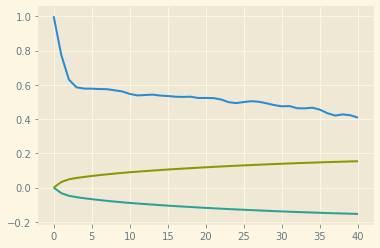

In [25]:
import matplotlib.pyplot as plt
plt.plot(alag)
plt.plot(acf_conf)

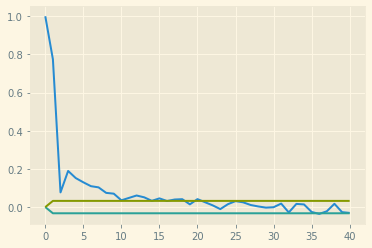

In [26]:
plt.plot(palag)
plt.plot(pacf_conf)